In [1]:
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
benign_data_path = 'Adversarial_traffic_None.csv'
attack_data_path = 'Adversarial_traffic_Both.csv'

In [3]:
benign = pd.read_csv(benign_data_path)
attack = pd.read_csv(attack_data_path)
benign.head()

,TS,ID,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,Label
0,0.000000,000,8,00,00,00,00,00,00,00,00,1
1,0.005460,000,8,00,00,00,00,00,00,00,00,1
2,0.011176,140,8,00,00,00,00,1c,07,26,28,0
3,0.016722,000,8,00,00,00,00,00,00,00,00,1
4,0.016960,316,8,05,21,74,09,21,20,00,6f,0


In [4]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [5]:
def construct_payload(row):
    dlc = int(row["DLC"])  # Number of valid data columns
    data_values = [row[f"Data{i}"] for i in range(1, dlc + 1) if f"Data{i}" in row]
    return "".join(map(str, data_values))

In [6]:
benign.rename(columns={"TS" : "Timestamp"}, inplace=True)
attack['Label'].replace({2:1, 3:1}, inplace=True)

/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_2758/3729642295.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  attack['Label'].replace({2:1, 3:1}, inplace=True)


In [7]:
benign["Payload"] = benign.apply(construct_payload, axis=1)
attack["Payload"] = attack.apply(construct_payload, axis=1)

In [8]:
benign = benign[["Timestamp", "ID", "DLC", "Payload", "Label"]]
attack = attack[["TS", "ID", "DLC", "Payload", "Label"]]
attack.columns = ["Timestamp", "ID", "DLC", "Payload", "label"]

In [9]:
hex_to_dec = lambda x: int(str(x), 16) if isinstance(x, str) else x

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

benign = transform_data(benign)
attack = transform_data(attack)

In [10]:
def calculate_periodicity(data, return_df=False):
    """
    Periodicity is the time difference between two consecutive packets of the same ID.
    - For the first packet of each ID, the periodicity is 0.
    - For the first packet in the dataset the IAT will be 0.

    Parameters:
        data (pd.DataFrame): DataFrame with at least 'Timestamp' and 'ID' columns.
        return_df (bool): If True, returns original DataFrame with 'Periodicity' column.
                          If False, returns a dictionary with mean periodicity per ID.

    Returns:
        pd.DataFrame or dict
    """
    # Ensure Timestamp is in datetime format
    # data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
    # Calculate periodicity as time difference within each ID
    data['Periodicity'] = data.groupby('ID')['Timestamp'].diff()
    # data['Periodicity'] = data.groupby('ID')['Timestamp'].diff().dt.total_seconds()
    data['Periodicity'] = data['Periodicity'].fillna(0)

    if return_df:
        return data
    else:
        ##Mean and std-dev of periodicity per ID in a dictionary, the key is the ID, the value is list of mean and std-dev
        periodicity_dict = {}
        for id_val in data['ID'].unique():
            periodicity_dict[id_val] = [data[data['ID'] == id_val]['Periodicity'].mean(), 
                                         data[data['ID'] == id_val]['Periodicity'].std()]
        
        return periodicity_dict

benign_periodicity = calculate_periodicity(benign)
attack_data = calculate_periodicity(attack, return_df=True)

In [11]:
attack_data

,Timestamp,ID,DLC,Payload,label,Periodicity
0,0.000000,763,8,16014210921527346713,1,0.000000
1,0.005492,1603,8,16023598002644792539,1,0.000000
2,0.011240,320,8,470230568,0,0.000000
3,0.016786,1759,8,409939062902748317,1,0.000000
4,0.017052,790,8,369704226980364399,0,0.000000
...,...,...,...,...,...,...
80496,66.876800,399,8,18327398683588493312,0,0.009308
80497,66.877030,608,8,1883105183891680516,0,0.009310
80498,66.877266,672,8,288399828029979904,0,0.009312
80499,66.877502,809,8,4663054188352110612,0,0.009316


Using mean +/- std-dev
Accuracy: 0.7899
F1 Score: 0.4227
TPR: 0.3109
FPR: 0.0526
TNR: 0.9474
FNR: 0.6891

              precision    recall  f1-score   support

      Benign       0.81      0.95      0.87     60576
      Attack       0.66      0.31      0.42     19925

    accuracy                           0.79     80501
   macro avg       0.73      0.63      0.65     80501
weighted avg       0.77      0.79      0.76     80501



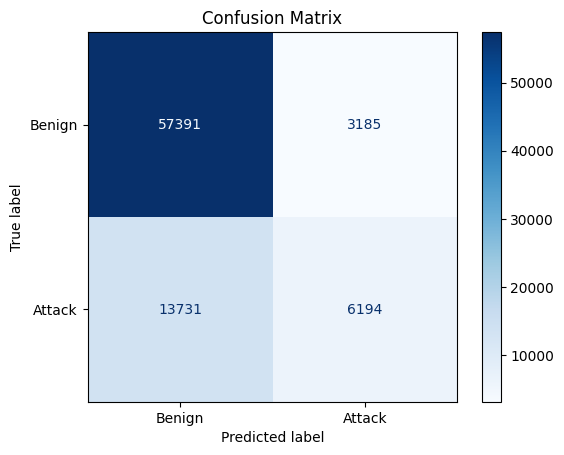

Using mean only
Accuracy: 0.3190
F1 Score: 0.3967
TPR: 0.9045
FPR: 0.8736
TNR: 0.1264
FNR: 0.0955

              precision    recall  f1-score   support

      Benign       0.80      0.13      0.22     60576
      Attack       0.25      0.90      0.40     19925

    accuracy                           0.32     80501
   macro avg       0.53      0.52      0.31     80501
weighted avg       0.67      0.32      0.26     80501



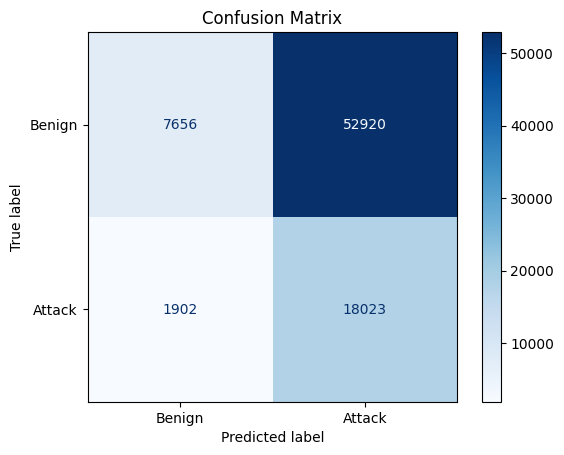

In [12]:
def make_predictions(benign_periodicity, dos_data, use_range=True):
   
    ##Make predictions per packet using benign_periodicity mean and std-dev
    ## For each packet in dos_data, check if the periodicity is within the mean +/- std-dev of the benign data

    predictions = []
    true_labels = dos_data['label'].values

    for index, row in dos_data.iterrows():
        id_val = row['ID']
        periodicity = row['Periodicity']

        if use_range:
            if id_val in benign_periodicity:
                mean, std_dev = benign_periodicity[id_val]
                lower_bound = mean - std_dev
                upper_bound = mean + std_dev

                if lower_bound <= periodicity <= upper_bound:
                    predictions.append(0)
                else:
                    predictions.append(1)
            else:
                predictions.append(1)
        else:
            if id_val in benign_periodicity:
                mean, _ = benign_periodicity[id_val]
                if periodicity < mean:
                    predictions.append(1)
                else:
                    predictions.append(0)
            else:
                predictions.append(1) 
        
    if use_range:
        print("Using mean +/- std-dev")
    else:
        print("Using mean only")

    ##Convert predictions to numpy array
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    ##Calculate and print accuracy, F1 Score, TPR, FPR, TNR, FNR
    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    TPR = recall  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    #Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"TPR: {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"TNR: {TNR:.4f}")
    print(f"FNR: {FNR:.4f}")

    print("")
    print(classification_report(true_labels, predictions, target_names=['Benign', 'Attack']))

    ##Plot confusion matrix with seaborn
    cm = confusion_matrix(true_labels, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return predictions

range_preds = make_predictions(benign_periodicity, attack_data, use_range=True)
mean_preds = make_predictions(benign_periodicity, attack_data, use_range=False)

In [13]:
attack_data['Preds'] = range_preds

##Print the rows where label is 0 and prediction is 1 and periodicity is not 0
benign_attack = attack_data[(attack_data['label'] == 0) & (attack_data['Preds'] == 1) & (attack_data['Periodicity'] != 0)]
benign_attack = benign_attack[['ID', 'DLC', 'Payload', 'Periodicity', 'label', 'Preds']]

In [14]:
#For each key in in benign_periodicity print mean-std-dev | mean | mean + std-dev
for key in benign_periodicity.keys():
    mean, std_dev = benign_periodicity[key]
    print(f"{key}: {mean-std_dev} | {mean+std_dev}")
    

0: -0.07211965618576394 | 0.08299788694867763
320: -0.02523707552698974 | 0.06459972610170239
790: -0.022661108352074247 | 0.06423296389076924
1088: -0.02671703577300737 | 0.06706507112951886
809: -0.026257680259099452 | 0.06673726169569419
305: -0.024330627410963736 | 0.06554685739290234
1072: -0.043345204319441284 | 0.12353015803941786
497: -0.04787570893967235 | 0.12395452606029492
339: -0.021905891087953502 | 0.08831310700255807
2: -0.02616276704800114 | 0.06479730388119334
304: -0.020519128540147428 | 0.06760620937950071
1680: -0.19395159866564904 | 0.6124660206839976
848: -0.025032098925811864 | 0.06746489892581187
1349: -0.02664599282250114 | 0.07021814059320178
880: -0.02088688264346632 | 0.05998137135452662
1087: -0.021585879439702305 | 0.06414627645277013
608: -0.02548832274987982 | 0.0655674156300439
672: -0.020417736562753776 | 0.060697311356628925
399: -0.0189219062280168 | 0.05903023721393229
1264: -0.04262684057763442 | 0.1235836064341845
1201: -0.03970120064790657 | 0.1

In [15]:
##Now we will do frequency mode analysis for every ID
## Frequency for each packet is defined as the number of packets with the same ID in the dataset, in a given time period
## For the first packet of each ID, the frequency is 0.
## For the benign data we will generate frequency for each unique ID, (timestamp of last packet - timestamp of first packet)/num_packets
## And return in a dictionary

def generate_benign_frequencies(benign_data):
    """
    Function to generate frequency for each unique ID in the benign data
    Frequency is defined as (timestamp of last packet - timestamp of first packet)/num_packets
    """

    # Ensure Timestamp is in datetime format
    # benign_data['Timestamp'] = pd.to_datetime(benign_data['Timestamp'], unit='s')

    frequency_dict = {}
    
    for id_val in benign_data['ID'].unique():
        id_data = benign_data[benign_data['ID'] == id_val]
        num_packets = len(id_data)
        time_diff = id_data['Timestamp'].iloc[-1] - id_data['Timestamp'].iloc[0]
        frequency = time_diff / num_packets
        frequency_dict[id_val] = frequency

    return frequency_dict

benign_frequencies = generate_benign_frequencies(benign)


In [16]:
print(benign_frequencies)

{0: 0.005439115381456845, 320: 0.019681325287356322, 790: 0.020785927769347495, 1088: 0.020174017678255742, 809: 0.02023979071829737, 305: 0.020608114990969293, 1072: 0.040092476859988284, 497: 0.03803940856031129, 339: 0.03320360795730228, 2: 0.019317268416596103, 304: 0.02354354041967664, 1680: 0.20925721100917427, 848: 0.021216400000000003, 1349: 0.02178607388535032, 880: 0.019547244355530152, 1087: 0.021280198506533912, 608: 0.02003954644008204, 672: 0.020139787396937572, 399: 0.020054165492957746, 1264: 0.04047838292827504, 1201: 0.03795046273637375, 704: 0.021019636812847436, 1520: 0.11045500162601626, 160: 0.20207306865671643, 161: 0.19225714956011733, 1440: 2.245129, 1442: 2.328342740740741}


In [17]:
attack_data.drop(['Preds'], axis=1, inplace=True)
def generate_attack_frequencies(attack_data, time_period):
    """
    For each packet in attack_data, calculate frequency as:
    Number of packets with the same ID in the past `time_period` seconds.
    """
    # Ensure timestamps are in datetime format and data is sorted
    attack_data['Timestamp'] = pd.to_datetime(attack_data['Timestamp'], unit='s')
    # attack_data = attack_data.sort_values(['ID', 'Timestamp']).reset_index(drop=True)
    
    # Initialize the frequency column
    attack_data['Frequency'] = 0.0

    # Group by ID for efficient processing
    grouped = attack_data.groupby('ID')

    result = []

    for id_val, group in grouped:
        timestamps = group['Timestamp'].values.astype('datetime64[s]').astype('int64')
        freq_list = []
        start = 0
        
        for i in range(len(timestamps)):
            # Move start index to maintain the window
            while timestamps[i] - timestamps[start] > time_period:
                start += 1
            freq_list.append(i - start)  # number of previous packets in window

        group['Frequency'] = freq_list
        result.append(group)

    attack_data = pd.concat(result).sort_index()
    return attack_data

attack_data_frequencies = generate_attack_frequencies(attack_data, time_period=1)

In [18]:
def generate_predictions(attack_data, time_period):

    attack_data_frequencies = generate_attack_frequencies(attack_data, time_period=time_period)

    labels = attack_data_frequencies['label'].values
    predictions = []

    for idx, row in attack_data_frequencies.iterrows():
        id = row['ID']
        frequency = row['Frequency']

        if id in benign_frequencies:
            if frequency > 2 * benign_frequencies[id]:
                predictions.append(1)
            else:
                predictions.append(0)
        else:
            predictions.append(1)

    predictions = np.array(predictions)

    ##Calculate and print accuracy, F1 Score, TPR, FPR, TNR, FNR
    TP = np.sum((predictions == 1) & (labels == 1))
    TN = np.sum((predictions == 0) & (labels == 0))
    FP = np.sum((predictions == 1) & (labels == 0))
    FN = np.sum((predictions == 0) & (labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    TPR = recall  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    #Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"TPR: {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"TNR: {TNR:.4f}")
    print(f"FNR: {FNR:.4f}")

    print("")
    print(classification_report(labels, predictions, target_names=['Benign', 'Attack']))

    ##Plot confusion matrix with seaborn
    cm = confusion_matrix(labels, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


Time Period: 1e-06 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



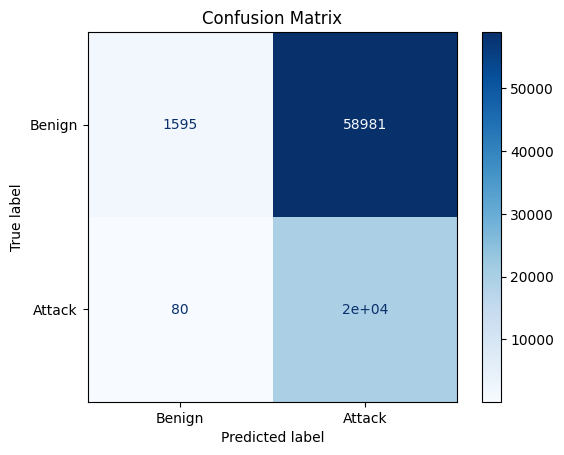



Time Period: 1e-05 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



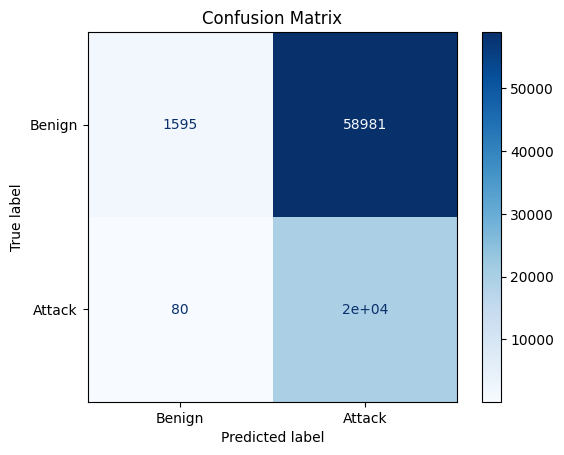



Time Period: 0.0001 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



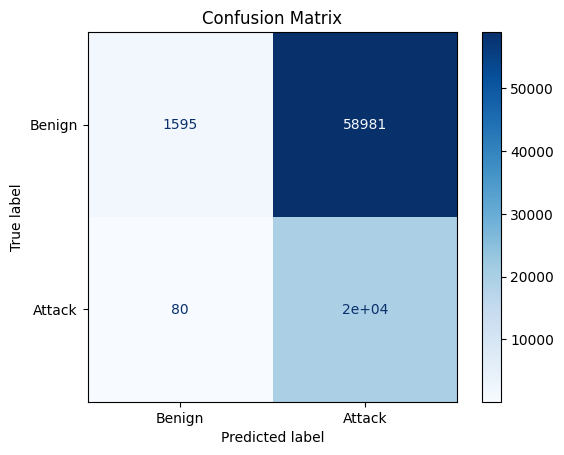



Time Period: 0.001 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



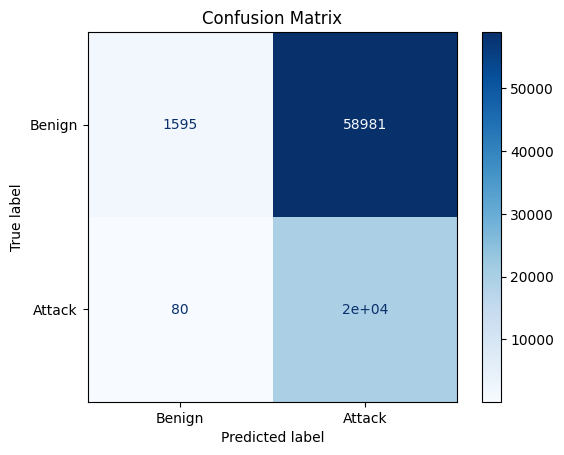



Time Period: 0.01 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



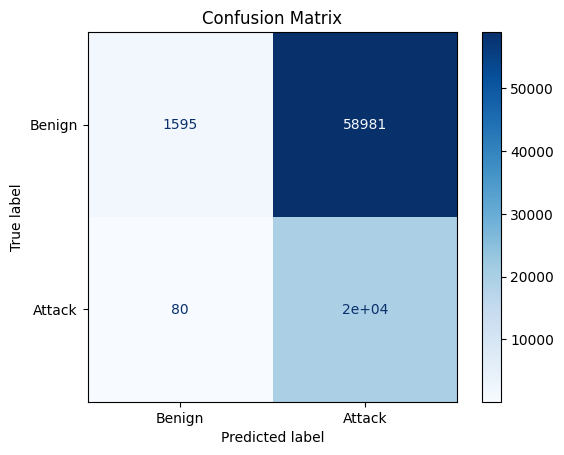



Time Period: 0.1 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



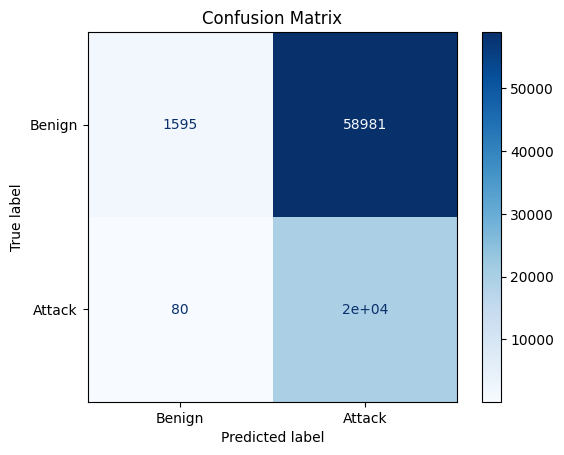



Time Period: 0.5 seconds
Accuracy: 0.2663
F1 Score: 0.4019
TPR: 0.9960
FPR: 0.9737
TNR: 0.0263
FNR: 0.0040

              precision    recall  f1-score   support

      Benign       0.95      0.03      0.05     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.27     80501
   macro avg       0.60      0.51      0.23     80501
weighted avg       0.78      0.27      0.14     80501



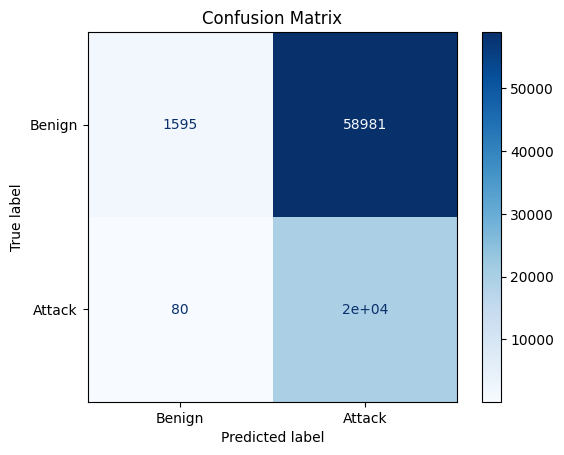



Time Period: 1 seconds
Accuracy: 0.2486
F1 Score: 0.3970
TPR: 0.9994
FPR: 0.9983
TNR: 0.0017
FNR: 0.0006

              precision    recall  f1-score   support

      Benign       0.90      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.57      0.50      0.20     80501
weighted avg       0.74      0.25      0.10     80501



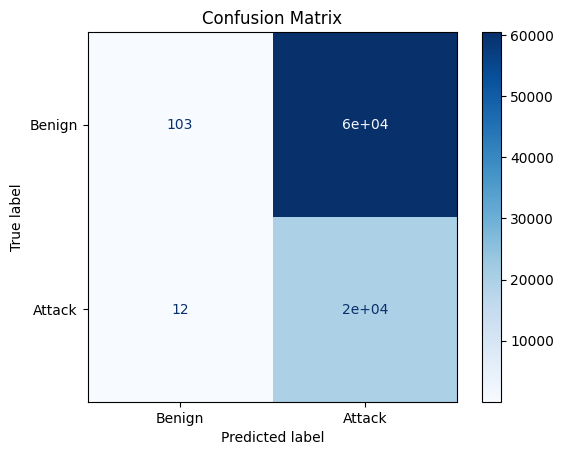



Time Period: 2 seconds
Accuracy: 0.2484
F1 Score: 0.3970
TPR: 0.9995
FPR: 0.9986
TNR: 0.0014
FNR: 0.0005

              precision    recall  f1-score   support

      Benign       0.89      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.57      0.50      0.20     80501
weighted avg       0.73      0.25      0.10     80501



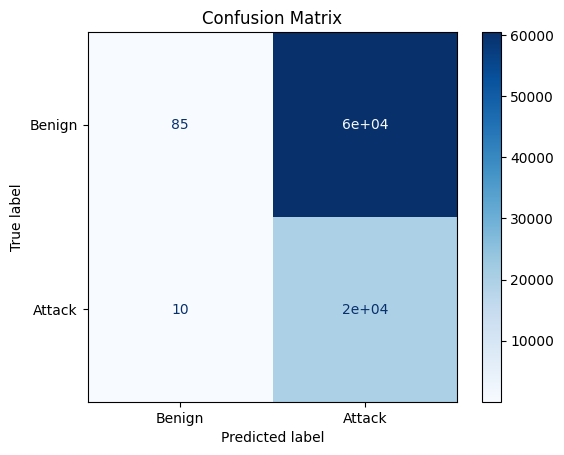



Time Period: 5 seconds
Accuracy: 0.2485
F1 Score: 0.3971
TPR: 0.9999
FPR: 0.9987
TNR: 0.0013
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.97      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.61      0.50      0.20     80501
weighted avg       0.79      0.25      0.10     80501



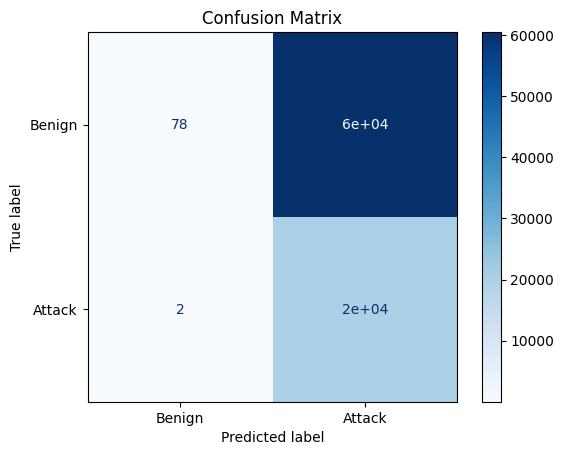



Time Period: 10 seconds
Accuracy: 0.2482
F1 Score: 0.3970
TPR: 0.9999
FPR: 0.9990
TNR: 0.0010
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.97      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.61      0.50      0.20     80501
weighted avg       0.79      0.25      0.10     80501



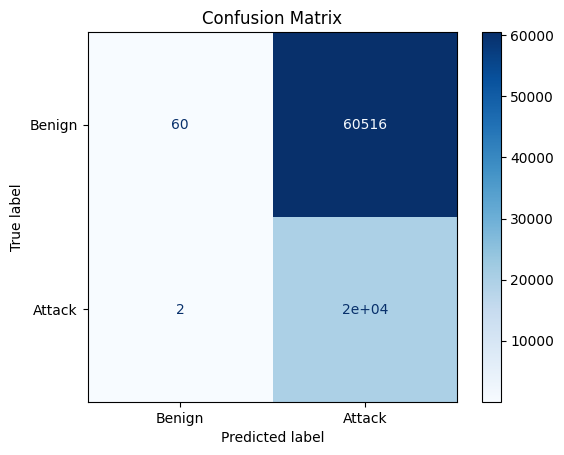



Time Period: 20 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



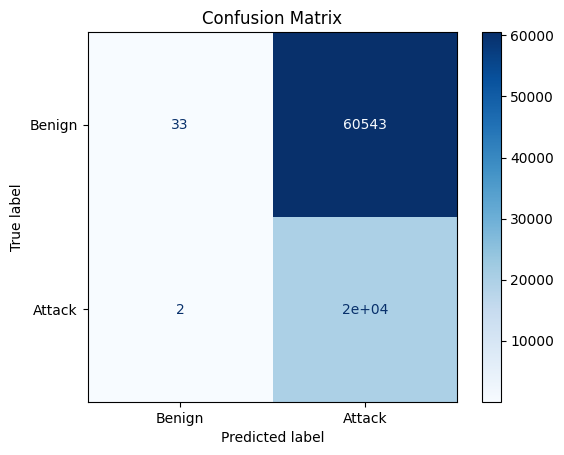



Time Period: 30 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



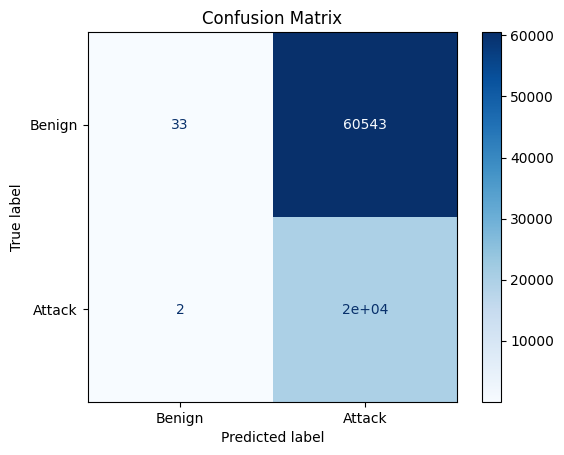



Time Period: 60 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



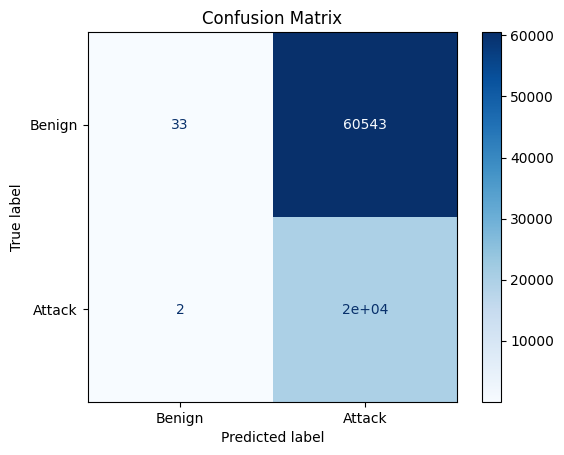



Time Period: 120 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



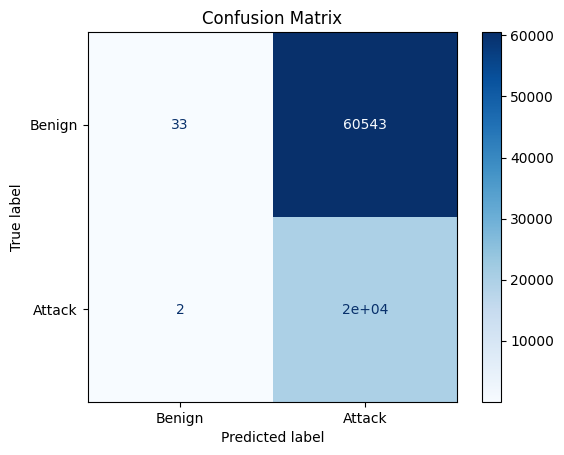



Time Period: 180 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



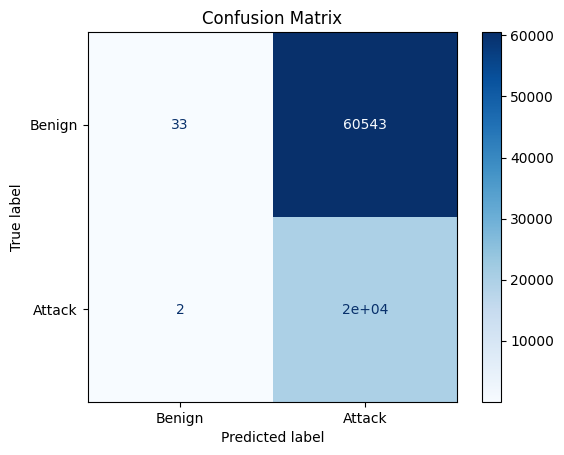



Time Period: 240 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



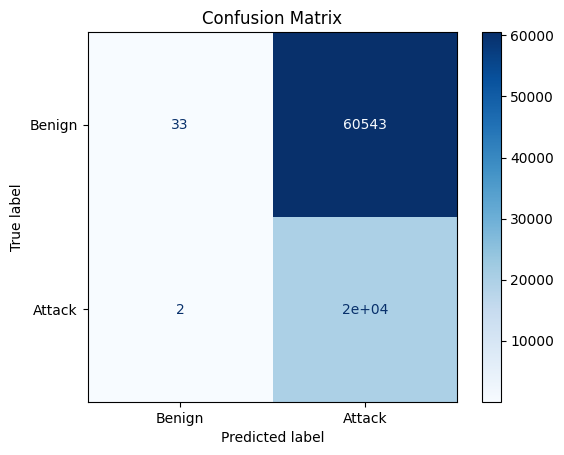



Time Period: 300 seconds
Accuracy: 0.2479
F1 Score: 0.3969
TPR: 0.9999
FPR: 0.9995
TNR: 0.0005
FNR: 0.0001

              precision    recall  f1-score   support

      Benign       0.94      0.00      0.00     60576
      Attack       0.25      1.00      0.40     19925

    accuracy                           0.25     80501
   macro avg       0.60      0.50      0.20     80501
weighted avg       0.77      0.25      0.10     80501



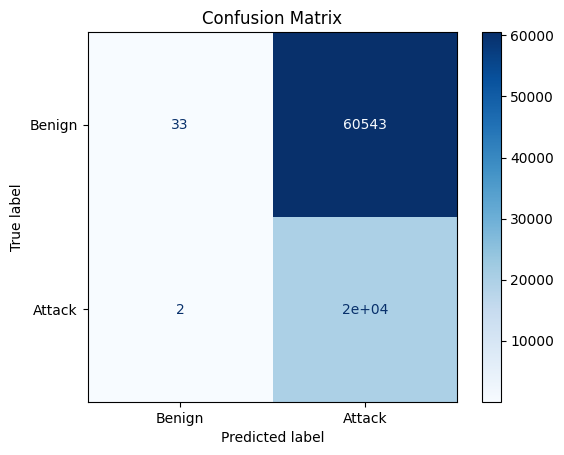

In [19]:
time_periods = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2,0.1, 0.5, 1, 2, 5, 10, 20, 30, 60, 120, 180, 240, 300] # in seconds

for time_period in time_periods:
    print(f"Time Period: {time_period} seconds")
    generate_predictions(attack_data, time_period)
    print("\n" + "="*50 + "\n")